# Proyecto 3 Minería de Datos
## Integrantes:
- Carlos Valladares, 221164
- Julio Lemus, 22461
- Hugo Rivas, 22500
- Alexis Mesias, 22562

### Carga de datos y unión de tablas

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y transformación
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
)
from sklearn.impute import SimpleImputer
from scipy.stats import zscore

# División y validación
from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score,
    GridSearchCV, RandomizedSearchCV
)

# Modelado
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Pipelines y transformadores
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Métricas
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    make_scorer
)

# Reducción de dimensionalidad
from sklearn.decomposition import TruncatedSVD

# Utilidades
from time import time
import warnings


In [2]:

orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
customers = pd.read_csv("data/olist_customers_dataset.csv")

# Convertir fechas a formato datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

# Calcular el tiempo de entrega en días
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Unir las tablas necesarias
df = orders.merge(order_items, on='order_id', how='left') \
           .merge(products, on='product_id', how='left') \
           .merge(reviews, on='order_id', how='left') \
           .merge(customers, on='customer_id', how='left')

# Mantener solo las columnas clave
df = df[['order_id', 'customer_id', 'order_purchase_timestamp', 'delivery_time',
         'price', 'freight_value', 'review_score', 'product_category_name',
         'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']]

print("df creado correctamente con shape:", df.shape)


df creado correctamente con shape: (114092, 12)


### Análisis Exploratorio de Datos (EDA)

In [32]:
# Revisión de valores nulos por columna
valores_nulos = df.isnull().sum()
porcentaje_nulos = (df.isnull().mean() * 100).round(2)
nulos_df = pd.DataFrame({
    "Valores Nulos": valores_nulos,
    "Porcentaje": porcentaje_nulos
})
print("Valores nulos por columna:")
display(nulos_df[nulos_df["Valores Nulos"] > 0])

# Revisión de filas duplicadas
duplicados = df.duplicated().sum()
print(f"\nTotal de filas duplicadas: {duplicados}")


Valores nulos por columna:


,Valores Nulos,Porcentaje



Total de filas duplicadas: 10369


       delivery_time          price  freight_value   review_score  \
count  108478.000000  108478.000000  108478.000000  108478.000000   
mean       11.965919     119.797846      19.966495       4.083160   
std         9.350419     180.453399      15.699066       1.345792   
min         0.000000       0.850000       0.000000       1.000000   
25%         6.000000      39.900000      13.080000       4.000000   
50%        10.000000      74.900000      16.280000       5.000000   
75%        15.000000     134.000000      21.150000       5.000000   
max       208.000000    6735.000000     409.680000       5.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count     108478.000000      108478.000000      108478.000000   
mean        2091.902754          30.195136          16.569710   
std         3739.598453          16.140261          13.422971   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           

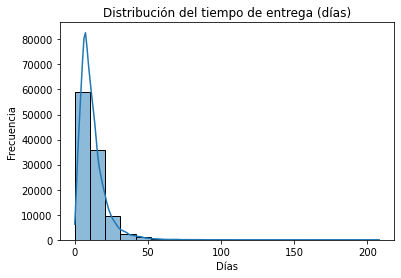

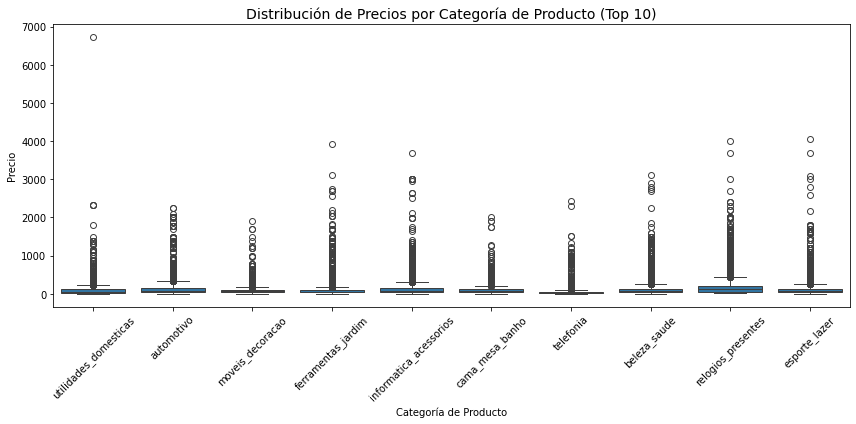

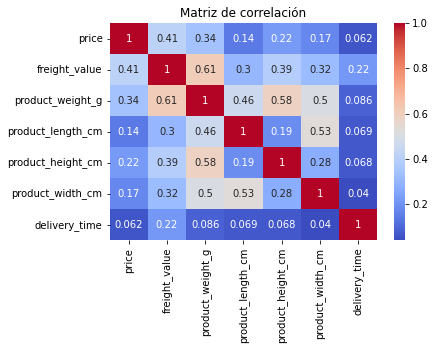

In [33]:


# Resumen estadístico
print(df.describe())

# Histograma del tiempo de entrega
sns.histplot(df['delivery_time'].dropna(), bins=20, kde=True)
plt.title("Distribución del tiempo de entrega (días)")
plt.xlabel("Días")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot del precio por categoría con mejoras
plt.figure(figsize=(12, 6))
top_cats = df['product_category_name'].value_counts().head(10).index
sns.boxplot(data=df[df['product_category_name'].isin(top_cats)],
            x='product_category_name', y='price')
plt.xticks(rotation=45)
plt.title("Distribución de Precios por Categoría de Producto (Top 10)", fontsize=14)
plt.xlabel("Categoría de Producto")
plt.ylabel("Precio")
plt.tight_layout()
plt.show()


# Matriz de correlación
num_vars = ['price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'delivery_time']
corr = df[num_vars].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

### Preprocesamiento del Dataset

In [34]:


# ======== 1. PREPROCESAMIENTO GENERAL (Refactorizado) ========

def preprocesar_para_modelado(df):
    columnas = [
        'price', 'delivery_time', 'review_score', 'product_category_name',
        'freight_value', 'product_weight_g', 'product_length_cm',
        'product_height_cm', 'product_width_cm'
    ]
    
    df_model = df.dropna(subset=columnas).copy()

    # Codificación y variable objetivo
    le = LabelEncoder()
    df_model['product_category_encoded'] = le.fit_transform(df_model['product_category_name'])
    df_model['satisfaccion'] = df_model['review_score'].apply(lambda x: 1 if x >= 4 else 0)

    features = ['price', 'freight_value', 'product_weight_g', 'product_length_cm',
                'product_height_cm', 'product_width_cm', 'product_category_encoded']

    X = df_model[features]
    y_reg = df_model['delivery_time']
    y_clf = df_model['satisfaccion']

    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

    return df_model, X_train_reg, X_test_reg, y_train_reg, y_test_reg, X_train_clf, X_test_clf, y_train_clf, y_test_clf

# Ejecutar preprocesamiento
df_model, X_train_reg, X_test_reg, y_train_reg, y_test_reg, X_train_clf, X_test_clf, y_train_clf, y_test_clf = preprocesar_para_modelado(df)

# ======== 2. REGRESIÓN ========
X_train_sample = X_train_reg.sample(3000, random_state=42)
y_train_sample = y_train_reg.loc[X_train_sample.index]

models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)
}

print("REGRESIÓN")
for name, model in models_reg.items():
    model.fit(X_train_sample, y_train_sample)
    y_pred = model.predict(X_test_reg)

    print(f"\n {name}")
    print("MAE:", round(mean_absolute_error(y_test_reg, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test_reg, y_pred)), 2))
    print("R²:", round(r2_score(y_test_reg, y_pred), 4))

# ======== 3. CLASIFICACIÓN ========
X_train_clf_sample = X_train_clf.sample(5000, random_state=42)
y_train_clf_sample = y_train_clf.loc[X_train_clf_sample.index]

X_test_clf = X_test_clf.dropna()
y_test_clf = y_test_clf.loc[X_test_clf.index]

models_clf = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42)
}

print("\nCLASIFICACIÓN")
for name, model in models_clf.items():
    model.fit(X_train_clf_sample, y_train_clf_sample)
    y_pred = model.predict(X_test_clf)

    print(f"\n {name}")
    print("Accuracy:", round(accuracy_score(y_test_clf, y_pred), 4))
    print("Precision:", round(precision_score(y_test_clf, y_pred), 4))
    print("Recall:", round(recall_score(y_test_clf, y_pred), 4))
    print("F1-score:", round(f1_score(y_test_clf, y_pred), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test_clf, y_pred))


REGRESIÓN

 Linear Regression
MAE: 6.01
RMSE: 8.94
R²: 0.0479

 Random Forest
MAE: 5.83
RMSE: 8.87
R²: 0.0624

CLASIFICACIÓN

 Logistic Regression
Accuracy: 0.7679
Precision: 0.7685
Recall: 0.999
F1-score: 0.8687
Confusion Matrix:
 [[    2  5019]
 [   16 16659]]

 Random Forest
Accuracy: 0.7464
Precision: 0.7781
Recall: 0.9373
F1-score: 0.8503
Confusion Matrix:
 [[  563  4458]
 [ 1045 15630]]


### Exportar el dataset preprocesado

In [5]:
df_model.to_csv("olist_dataset_modelado.csv", index=False)
print("Dataset exportado exitosamente como 'olist_dataset_modelado.csv'")

Dataset exportado exitosamente como 'olist_dataset_modelado.csv'


### MODELOS DE REGRESIÓN

Regresión Simple

Regresión Lineal Simple
Coeficiente (pendiente): 0.128269898043979
Intercepto: 9.404819025303238
MAE: 6.09
RMSE: 9.13
R²: 0.0464


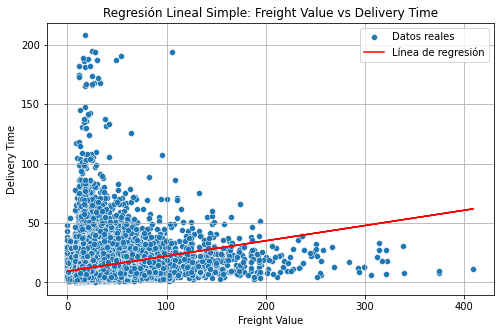

In [6]:


# Datos
x_simple = df_model[['freight_value']]
y_simple = df_model['delivery_time']

# Entrenamiento
model_simple = LinearRegression()
model_simple.fit(x_simple, y_simple)

# Predicción
y_pred_simple = model_simple.predict(x_simple)

# Métricas
print("Regresión Lineal Simple")
print("Coeficiente (pendiente):", model_simple.coef_[0])
print("Intercepto:", model_simple.intercept_)
print("MAE:", round(mean_absolute_error(y_simple, y_pred_simple), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_simple, y_pred_simple)), 2))  
print("R²:", round(r2_score(y_simple, y_pred_simple), 4))
plt.figure(figsize=(8,5))
sns.scatterplot(x=x_simple['freight_value'], y=y_simple, label='Datos reales')
plt.plot(x_simple, y_pred_simple, color='red', label='Línea de regresión')
plt.xlabel('Freight Value')
plt.ylabel('Delivery Time')
plt.title('Regresión Lineal Simple: Freight Value vs Delivery Time')
plt.legend()
plt.grid(True)
plt.show()

Aunque la línea de regresión sube un poco (es decir, hay una ligera relación positiva entre el costo de envío y el tiempo de entrega), la dispersión de los puntos es enorme. Eso quiere decir que el valor del transporte por sí solo no explica muy bien cuánto se va a tardar en llegar un pedido.
El R² es de apenas 0.046, o sea, la línea apenas explica el 4.6% del comportamiento real. En resumen, sí hay una tendencia, pero es tan débil que no podemos confiar mucho solo en este dato.

#### Ajuste de Parámetros

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

modelo_simple = LinearRegression()
scores_simple = cross_val_score(modelo_simple, x_simple, y_simple, scoring='neg_mean_squared_error', cv=5)

mse_simple = -scores_simple
rmse_simple = np.sqrt(mse_simple.mean())

print("RMSE promedio (Regresión Lineal Simple):", rmse_simple)


RMSE promedio (Regresión Lineal Simple): 9.131183943030653


Regresión múltiple

Regresión Lineal Múltiple
MAE: 6.05
RMSE: 9.11
R²: 0.0515


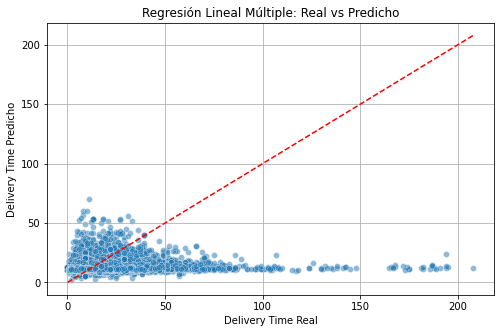

In [8]:
X_multi = df_model[['price', 'freight_value', 'product_weight_g',
                    'product_length_cm', 'product_height_cm',
                    'product_width_cm', 'product_category_encoded']]
y_multi = df_model['delivery_time']

# Modelo
model_multi = LinearRegression()
model_multi.fit(X_multi, y_multi)

# Predicción
y_pred_multi = model_multi.predict(X_multi)

# Métricas
print("Regresión Lineal Múltiple")
print("MAE:", round(mean_absolute_error(y_multi, y_pred_multi), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_multi, y_pred_multi)), 2))
print("R²:", round(r2_score(y_multi, y_pred_multi), 4))
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_multi, y=y_pred_multi, alpha=0.5)
plt.plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], 'r--')
plt.xlabel("Delivery Time Real")
plt.ylabel("Delivery Time Predicho")
plt.title("Regresión Lineal Múltiple: Real vs Predicho")
plt.grid(True)
plt.show()


Aquí ya usamos varias variables para predecir el tiempo de entrega, y aunque el modelo mejoró apenas un poco comparado con la regresión simple (el R2 subió a 0.0515, o sea, ahora explica el 5.1% del total), todavía le cuesta bastante predecir con precisión.  
La nube de puntos está bastante dispersa y muchos valores están lejos de la línea punteada ideal. En resumen, usar más variables sí ayudó pero no es suficiente. Probablemente hay factores fuera del dataset que están influyendo mucho más (como logística, zona de entrega, tráfico, etc).


### Ajuste de Parámetros

In [9]:
modelo_multiple = LinearRegression()
scores_multiple = cross_val_score(modelo_multiple, X_multi, y_multi, scoring='neg_mean_squared_error', cv=5)

# Convertimos a errores positivos y sacamos la media
mse_multiple = -scores_multiple
rmse_multiple = np.sqrt(mse_multiple.mean())

print("RMSE promedio (Regresión Lineal Múltiple):", rmse_multiple)


RMSE promedio (Regresión Lineal Múltiple): 9.107686165573913


Regresión polinomial


Regresión Polinomial (grado 2)
Coeficientes: [ 5.99063235e-03 -1.71525401e-06]
Intercepto: 11.328725049521395
MAE: 6.29
RMSE: 9.32
R²: 0.0057


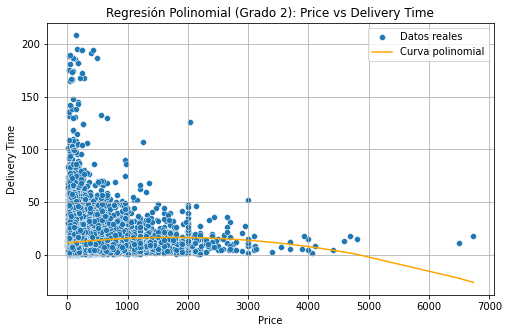

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# Variable base
X_poly_base = df_model[['price']]
y_poly = df_model['delivery_time']

# Transformación polinomial de grado 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_poly_base)

# Modelo
model_poly = LinearRegression()
model_poly.fit(X_poly, y_poly)

# Predicción
y_pred_poly = model_poly.predict(X_poly)

# Métricas
print("Regresión Polinomial (grado 2)")
print("Coeficientes:", model_poly.coef_)
print("Intercepto:", model_poly.intercept_)
print("MAE:", round(mean_absolute_error(y_poly, y_pred_poly), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_poly, y_pred_poly)), 2))
print("R²:", round(r2_score(y_poly, y_pred_poly), 4))

plt.figure(figsize=(8,5))
sorted_idx = X_poly_base['price'].argsort()
x_sorted = X_poly_base['price'].iloc[sorted_idx]
y_sorted = y_pred_poly[sorted_idx]

sns.scatterplot(x=X_poly_base['price'], y=y_poly, label='Datos reales')
plt.plot(x_sorted, y_sorted, color='orange', label='Curva polinomial')
plt.xlabel('Price')
plt.ylabel('Delivery Time')
plt.title('Regresión Polinomial (Grado 2): Price vs Delivery Time')
plt.legend()
plt.grid(True)
plt.show()


Aquí intentamos ajustar una curva en lugar de una línea, para ver si el precio del producto se relaciona de forma no lineal con el tiempo de entrega. Visualmente la curva se ve más “ajustada” que una recta, pero la verdad es que el modelo sigue sin capturar bien la realidad.
El R² es bajísimo (0.0057), lo que quiere decir que la relación entre el precio del producto y el tiempo de entrega prácticamente no existe o no es útil para predecir.

Ajuste de Parámetros

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X_poly_base = X_train_sample[['price']]
y_poly = y_train_sample

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_poly_base)

model_poly = LinearRegression()
model_poly.fit(X_poly, y_poly)

y_pred_poly = model_poly.predict(X_poly)  
rmse_poli = np.sqrt(np.mean((y_poly - y_pred_poly) ** 2))

print("RMSE promedio (Regresión Polinomial, grado 2):", round(rmse_poli, 2))


RMSE promedio (Regresión Polinomial, grado 2): 9.59


### árbol de decisión

Regresión con Árbol de Decisión
MAE: 1.46
RMSE: 3.81
R²: 0.8344


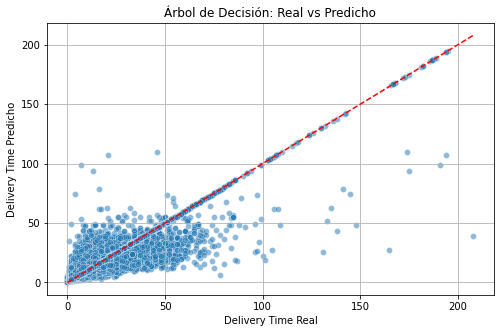

In [12]:
# Árbol de Decisión SIN split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_multi, y_multi)

# Predicción
y_pred_dt = dt_model.predict(X_multi)

# Métricas
print("Regresión con Árbol de Decisión")
print("MAE:", round(mean_absolute_error(y_multi, y_pred_dt), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_multi, y_pred_dt)), 2))
print("R²:", round(r2_score(y_multi, y_pred_dt), 4))

# Gráfico Real vs Predicho
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_multi, y=y_pred_dt, alpha=0.5)
plt.plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], 'r--')
plt.xlabel("Delivery Time Real")
plt.ylabel("Delivery Time Predicho")
plt.title("Árbol de Decisión: Real vs Predicho")
plt.grid(True)
plt.show()


En el caso del Árbol de Decisión, observamos una fuerte correspondencia visual entre los tiempos de entrega reales y predichos, donde la mayoría de los puntos se alinean bastante bien a la línea de referencia roja. El R cuadrado obtenido es de 0.8344, lo que indica un excelente poder predictivo: el modelo logra explicar más del 83% de la varianza en los datos de entrega. Tanto el MAE (1.46) como el RMSE (3.81) son bajos, confirmando que el modelo comete pocos errores absolutos y cuadrados. Esto sugiere que el Árbol de Decisión es altamente efectivo para este tipo de predicción.

### Random Forest

Regresión con Random Forest
MAE: 2.59
RMSE: 4.51
R²: 0.7671


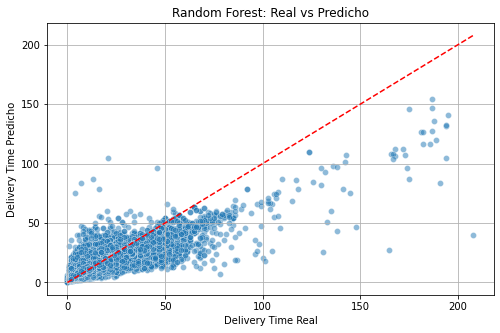

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_multi, y_multi)

# Predecir
y_pred_rf = rf_model.predict(X_multi)

# Métricas
print("Regresión con Random Forest")
print("MAE:", round(mean_absolute_error(y_multi, y_pred_rf), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_multi, y_pred_rf)), 2))
print("R²:", round(r2_score(y_multi, y_pred_rf), 4))

# Gráfico Real vs Predicho
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_multi, y=y_pred_rf, alpha=0.5)
plt.plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], 'r--')
plt.xlabel("Delivery Time Real")
plt.ylabel("Delivery Time Predicho")
plt.title("Random Forest: Real vs Predicho")
plt.grid(True)
plt.show()


Con Random Forest, el modelo también muestra un buen desempeño, aunque ligeramente inferior al Árbol de Decisión. El R cuadrado es de 0.7671, lo que indica que explica aproximadamente el 77% de la variabilidad en el tiempo de entrega. Visualmente, el ajuste es bueno, pero se observa una mayor dispersión alrededor de la línea roja. El MAE (2.59) y el RMSE (4.51) son mayores que en el Árbol de Decisión, pero siguen siendo razonables. Esto sugiere que Random Forest maneja bien los datos, pero no logra capturar algunas de las complejidades mejor que un solo árbol profundo.

### Support Vector Regression (SVR)

Regresión con SVR (muestra de 5000 registros)
MAE: 5.9
RMSE: 8.97
R²: -0.0495


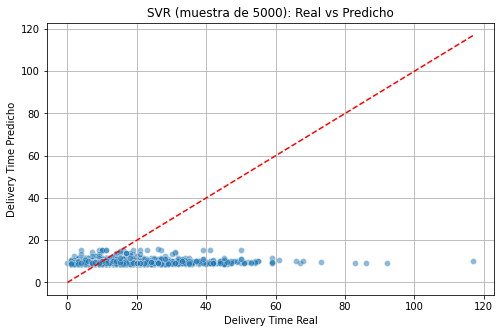

In [14]:
# ==================== FLUJO COMPLETO PARA SVR ====================



# 2. Cargar el dataset
# Cambia el path si es necesario dependiendo dónde esté tu archivo
df_model = pd.read_csv('olist_dataset_modelado.csv')

# 3. Definir X_multi e y_multi
X_multi = df_model[['price', 'freight_value', 'product_weight_g',
                    'product_length_cm', 'product_height_cm',
                    'product_width_cm', 'product_category_encoded']]

y_multi = df_model['delivery_time']

# 4. Crear muestra para SVR
X_svr_sample = X_multi.sample(5000, random_state=42)
y_svr_sample = y_multi.loc[X_svr_sample.index]

# 5. Entrenar modelo SVR
svr_model = SVR(kernel='rbf')
svr_model.fit(X_svr_sample, y_svr_sample)

# 6. Predicción
y_pred_svr = svr_model.predict(X_svr_sample)

# 7. Métricas
print("Regresión con SVR (muestra de 5000 registros)")
print("MAE:", round(mean_absolute_error(y_svr_sample, y_pred_svr), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_svr_sample, y_pred_svr)), 2))
print("R²:", round(r2_score(y_svr_sample, y_pred_svr), 4))

# 8. Gráfico Real vs Predicho
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_svr_sample, y=y_pred_svr, alpha=0.5)
plt.plot([y_svr_sample.min(), y_svr_sample.max()], [y_svr_sample.min(), y_svr_sample.max()], 'r--')
plt.xlabel("Delivery Time Real")
plt.ylabel("Delivery Time Predicho")
plt.title("SVR (muestra de 5000): Real vs Predicho")
plt.grid(True)
plt.show()


El modelo SVR, aplicado sobre una muestra de 5000 datos, muestra resultados pobres. Visualmente, los puntos predichos se agrupan cerca de valores bajos de tiempo de entrega, sin seguir la tendencia real de los datos. El R cuadrado obtenido es negativo (-0.0495), lo que indica que el modelo es incluso peor que simplemente predecir el promedio de los datos. Tanto el MAE (5.9) como el RMSE (8.97) son relativamente altos en comparación con los otros modelos. Esto confirma que SVR no es un modelo adecuado para predecir el tiempo de entrega en este conjunto de datos, probablemente debido a su sensibilidad a conjuntos de datos grandes y no lineales.

## Pipeline

In [15]:



# Cargar el dataset correcto
df_model = pd.read_csv('olist_dataset_modelado.csv')

# Revisar columnas disponibles
df_model.head()

# Variables predictoras y variable objetivo
X = df_model[['price', 'freight_value', 'product_weight_g',
              'product_length_cm', 'product_height_cm',
              'product_width_cm', 'product_category_encoded']]
y = df_model['delivery_time']

# División entre entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirmar tamaños de los datos
print("Shape de X_train:", X_train_scaled.shape)
print("Shape de X_test:", X_test_scaled.shape)


Shape de X_train: (86782, 7)
Shape de X_test: (21696, 7)


## Metricas

In [16]:
# MÉTRICAS FINALES PARA LOS 6 MODELOS


# Crear lista para guardar resultados
resultados = []

# Regresión Lineal Simple
mae_simple = mean_absolute_error(y_simple, y_pred_simple)
rmse_simple = np.sqrt(mean_squared_error(y_simple, y_pred_simple))
r2_simple = r2_score(y_simple, y_pred_simple)

resultados.append({
    'Modelo': 'Regresión Lineal Simple',
    'MAE': round(mae_simple, 2),
    'RMSE': round(rmse_simple, 2),
    'R²': round(r2_simple, 4)
})

# Regresión Lineal Múltiple
mae_multi = mean_absolute_error(y_multi, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y_multi, y_pred_multi))
r2_multi = r2_score(y_multi, y_pred_multi)

resultados.append({
    'Modelo': 'Regresión Lineal Múltiple',
    'MAE': round(mae_multi, 2),
    'RMSE': round(rmse_multi, 2),
    'R²': round(r2_multi, 4)
})

# Regresión Polinomial
mae_poly = mean_absolute_error(y_poly, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_poly, y_pred_poly))
r2_poly = r2_score(y_poly, y_pred_poly)

resultados.append({
    'Modelo': 'Regresión Polinomial (Grado 2)',
    'MAE': round(mae_poly, 2),
    'RMSE': round(rmse_poly, 2),
    'R²': round(r2_poly, 4)
})

# Árbol de Decisión
mae_dt = mean_absolute_error(y_multi, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_multi, y_pred_dt))
r2_dt = r2_score(y_multi, y_pred_dt)

resultados.append({
    'Modelo': 'Árbol de Decisión',
    'MAE': round(mae_dt, 2),
    'RMSE': round(rmse_dt, 2),
    'R²': round(r2_dt, 4)
})

# Random Forest
mae_rf = mean_absolute_error(y_multi, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_multi, y_pred_rf))
r2_rf = r2_score(y_multi, y_pred_rf)

resultados.append({
    'Modelo': 'Random Forest',
    'MAE': round(mae_rf, 2),
    'RMSE': round(rmse_rf, 2),
    'R²': round(r2_rf, 4)
})

# SVR (muestra 5000)
mae_svr = mean_absolute_error(y_svr_sample, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_svr_sample, y_pred_svr))
r2_svr = r2_score(y_svr_sample, y_pred_svr)

resultados.append({
    'Modelo': 'SVR (muestra 5000)',
    'MAE': round(mae_svr, 2),
    'RMSE': round(rmse_svr, 2),
    'R²': round(r2_svr, 4)
})

# Mostrar todo en tabla
df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,MAE,RMSE,R²
0,Regresión Lineal Simple,6.09,9.13,0.0464
1,Regresión Lineal Múltiple,6.05,9.11,0.0515
2,Regresión Polinomial (Grado 2),6.15,9.59,0.0026
3,Árbol de Decisión,1.46,3.81,0.8344
4,Random Forest,2.59,4.51,0.7671
5,SVR (muestra 5000),5.90,8.97,-0.0495


## Semana 3

### Implementación de Modelos de Clasificación

Logistic Regression

In [17]:


# Cargar el DataFrame
df = pd.read_csv('olist_dataset_modelado.csv')

# Revisar columnas categóricas y numéricas
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop('review_score', axis=1).columns.tolist()

# Separar X y y
X = df.drop('review_score', axis=1)
y = df['review_score']

# Pipeline: OneHot para categóricas + Escalado para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Crear pipeline completo (preprocesamiento + modelo)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar
clf.fit(X_train, y_train)

# Predecir
y_pred = clf.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 1979     0   471     0     0]
 [  292   240   204     0     0]
 [  767     3  1065     0     0]
 [    0     0     0   649  3530]
 [    0     0     0    19 12477]]
              precision    recall  f1-score   support

         1.0       0.65      0.81      0.72      2450
         2.0       0.99      0.33      0.49       736
         3.0       0.61      0.58      0.60      1835
         4.0       0.97      0.16      0.27      4179
         5.0       0.78      1.00      0.88     12496

    accuracy                           0.76     21696
   macro avg       0.80      0.57      0.59     21696
weighted avg       0.79      0.76      0.70     21696



Naive Bayes

In [18]:


# Separación de variables
X = df.drop('review_score', axis=1)
y = df['review_score']

# Columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ]
)

# Pipeline completo con SVD 
nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=100)),  
    ('classifier', GaussianNB())
])

# Split y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)

# Evaluación
print("Naive Bayes")
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes
[[   63  2267    49    23    48]
 [    5   705    12     3    11]
 [   21  1739    36     5    34]
 [   35  3808    82    28   226]
 [   96 11398   162   114   726]]
              precision    recall  f1-score   support

         1.0       0.29      0.03      0.05      2450
         2.0       0.04      0.96      0.07       736
         3.0       0.11      0.02      0.03      1835
         4.0       0.16      0.01      0.01      4179
         5.0       0.69      0.06      0.11     12496

    accuracy                           0.07     21696
   macro avg       0.26      0.21      0.05     21696
weighted avg       0.47      0.07      0.07     21696



K-Nearest Neighbors (KNN)

In [19]:

# Crear pipeline con KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Entrenar
knn_pipeline.fit(X_train, y_train)

# Predecir
y_pred_knn = knn_pipeline.predict(X_test)

# Evaluación
print("KNN")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KNN
[[ 1776   134   533     1     6]
 [  382   141   209     0     4]
 [  923   163   742     0     7]
 [    2     0     0   833  3344]
 [    2     0     1  1327 11166]]
              precision    recall  f1-score   support

         1.0       0.58      0.72      0.64      2450
         2.0       0.32      0.19      0.24       736
         3.0       0.50      0.40      0.45      1835
         4.0       0.39      0.20      0.26      4179
         5.0       0.77      0.89      0.83     12496

    accuracy                           0.68     21696
   macro avg       0.51      0.48      0.48     21696
weighted avg       0.64      0.68      0.65     21696



Árbol de Decisión

In [20]:

# Crear pipeline con Árbol de Decisión
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Entrenar
tree_pipeline.fit(X_train, y_train)

# Predecir
y_pred_tree = tree_pipeline.predict(X_test)

# Evaluación
print("Árbol de Decisión")
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Árbol de Decisión
[[ 1728   160   562     0     0]
 [  287   217   232     0     0]
 [  686   184   965     0     0]
 [    0     0     0  1134  3045]
 [    0     0     0  1467 11029]]
              precision    recall  f1-score   support

         1.0       0.64      0.71      0.67      2450
         2.0       0.39      0.29      0.33       736
         3.0       0.55      0.53      0.54      1835
         4.0       0.44      0.27      0.33      4179
         5.0       0.78      0.88      0.83     12496

    accuracy                           0.69     21696
   macro avg       0.56      0.54      0.54     21696
weighted avg       0.67      0.69      0.68     21696



Random Forest

In [21]:


# Cargar el dataset
df = pd.read_csv('olist_dataset_modelado.csv')

# Definir columnas categóricas y numéricas
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop('review_score', axis=1).columns.tolist()

# Crear preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Separar X y y
X = df.drop('review_score', axis=1)
y = df['review_score']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear pipeline con Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=30, max_depth=10, class_weight='balanced', random_state=42))
])


# Entrenar
rf_pipeline.fit(X_train, y_train)

# Predecir
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluación
print("Random Forest")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest
[[ 743   77 1630    0    0]
 [ 132   69  535    0    0]
 [ 212   64 1559    0    0]
 [   4    0    0 2334 1841]
 [   6    3    0 6660 5827]]
              precision    recall  f1-score   support

         1.0       0.68      0.30      0.42      2450
         2.0       0.32      0.09      0.15       736
         3.0       0.42      0.85      0.56      1835
         4.0       0.26      0.56      0.35      4179
         5.0       0.76      0.47      0.58     12496

    accuracy                           0.49     21696
   macro avg       0.49      0.45      0.41     21696
weighted avg       0.61      0.49      0.50     21696



Support Vector Machine (SVM)

In [22]:
# Cargar dataset y submuestrear 5000 filas
df = pd.read_csv('olist_dataset_modelado.csv')
df_sample = df.sample(n=5000, random_state=42)

X = df_sample.drop(columns='review_score')
y = df_sample['review_score']

# Identificar columnas categóricas y numéricas
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesador
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Pipeline con SVM limitado en iteraciones
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', max_iter=1000))
])

# Entrenamiento y predicción
svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)

# Evaluación
print("SVM (subsample + max_iter)")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


SVM (subsample + max_iter)
[[ 67   0  34   0   2]
 [ 19   0  17   0   0]
 [ 42   0  40   0   0]
 [  1   0   0   0 208]
 [  0   0   0   0 570]]
              precision    recall  f1-score   support

         1.0       0.52      0.65      0.58       103
         2.0       0.00      0.00      0.00        36
         3.0       0.44      0.49      0.46        82
         4.0       0.00      0.00      0.00       209
         5.0       0.73      1.00      0.84       570

    accuracy                           0.68      1000
   macro avg       0.34      0.43      0.38      1000
weighted avg       0.51      0.68      0.58      1000



c:\Users\Alexis Mesias\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Alexis Mesias\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alexis Mesias\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alexis Mesias\AppD

Logistic Regression (GridSearch)

In [23]:

df_sample = df.sample(5000, random_state=42)  # Limitamos a 5000 filas

# Separar X e y
X_sample = df_sample.drop('review_score', axis=1)
y_sample = df_sample['review_score']

# Split de la muestra limitada
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

# GridSearchCV
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'saga']
}

grid_search_lr = GridSearchCV(clf, param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_sample, y_train_sample)

print("Logistic Regression - mejores parámetros:", grid_search_lr.best_params_)
print("Mejor score (accuracy):", grid_search_lr.best_score_)

Logistic Regression - mejores parámetros: {'classifier__C': 0.01, 'classifier__solver': 'lbfgs'}
Mejor score (accuracy): 0.6942475873841024


KNN - GridSearch

In [24]:



knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]  
}

grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train_sample, y_train_sample)

print("KNN - mejores parámetros:", grid_search_knn.best_params_)
print("Mejor score (accuracy):", grid_search_knn.best_score_)

KNN - mejores parámetros: {'classifier__n_neighbors': 9, 'classifier__p': 2, 'classifier__weights': 'distance'}
Mejor score (accuracy): 0.6654990209321445


Árbol de Decisión - GridSearch

In [25]:


# Definir pipeline para Árbol de Decisión
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

param_grid_tree = {
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search_tree = GridSearchCV(tree_pipeline, param_grid_tree, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(X_train_sample, y_train_sample)

print("Árbol de Decisión - mejores parámetros:", grid_search_tree.best_params_)
print("Mejor score (accuracy):", grid_search_tree.best_score_)

Árbol de Decisión - mejores parámetros: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_split': 5}
Mejor score (accuracy): 0.6772508344477424


Random Forest - GridSearch

In [26]:


# Definir pipeline para Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'classifier__n_estimators': [10, 30, 50],
    'classifier__max_depth': [5, 10, 20],
    'classifier__class_weight': ['balanced', None]
}

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_sample, y_train_sample)

print("Random Forest - mejores parámetros:", grid_search_rf.best_params_)
print("Mejor score (accuracy):", grid_search_rf.best_score_)

Random Forest - mejores parámetros: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__n_estimators': 30}
Mejor score (accuracy): 0.6232641368737987


SVM - GridSearch

In [27]:


# Definir pipeline para SVM
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train_sample, y_train_sample)

print("SVM - mejores parámetros:", grid_search_svm.best_params_)
print("Mejor score (accuracy):", grid_search_svm.best_score_)

SVM - mejores parámetros: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
Mejor score (accuracy): 0.6937493368844461


Naive Bayes GridSearchCV

In [28]:
# Submuestreo para evitar problemas de memoria
df_sample = df.sample(5000, random_state=42)
X_sample = df_sample.drop('review_score', axis=1)
y_sample = df_sample['review_score']

# Split de datos
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# GridSearch 
param_grid_nb = {
    'svd__n_components': [20, 30, 50]
}

# GridSearchCV
grid_search_nb = GridSearchCV(nb_pipeline, param_grid_nb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train, y_train)

# Resultados
print("Naive Bayes  mejores parámetros:", grid_search_nb.best_params_)
print("Mejor score (accuracy):", grid_search_nb.best_score_)


Naive Bayes  mejores parámetros: {'svd__n_components': 20}
Mejor score (accuracy): 0.6172525140280573


## Semana 4

Carga y preprocesamiento

In [29]:


def carga_preprocesamiento_data(file_path, target, features, scaler_type='standard', impute_strategy='mean', outlier_threshold=3):
    # Carga de datos
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
    except FileNotFoundError:
        raise FileNotFoundError(f"El archivo {file_path} no se encuentra")
    
    # Validación inicial
    if df.empty:
        raise ValueError("El dataset está vacío")
    if not all(col in df.columns for col in features + [target]):
        raise ValueError("Algunas columnas no existen en el dataset")

    # Extraer X e y
    X = df[features].copy()
    y = df[target].copy()
    
    # Manejo de valores faltantes
    initial_rows = X.shape [0]
    mask = X.notna().all(axis=1) & y.notna()
    missing_rows = initial_rows - mask.sum()
    print(f"Filas con valores faltantes: {missing_rows} ({missing_rows/initial_rows*100:.2f}%)")
    
    # Imputación
    imputer = SimpleImputer(strategy=impute_strategy)
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    y = y[mask].reset_index(drop=True)  # Alinear y con filas válidas
    print(f"Valores faltantes imputados con estrategia '{impute_strategy}'")
    
    # Transformación de variables sesgadas 
    skewed_features = ['price', 'freight_value', 'product_weight_g', 'product_length_cm', 
                       'product_height_cm', 'product_width_cm']
    for feature in skewed_features:
        if feature in X.columns:
            skewness = X[feature].skew()
            if abs(skewness) > 1:  
                X[feature] = np.log1p(X[feature])  
                print(f"Transformación logarítmica aplicada a '{feature}' (sesgo: {skewness:.2f})")
    
    # Manejo de outliers
    z_scores = np.abs(zscore(X[skewed_features]))
    mask_outliers = (z_scores < outlier_threshold).all(axis=1)
    X = X[mask_outliers].reset_index(drop=True)
    y = y[mask_outliers].reset_index(drop=True)
    removed_outliers = initial_rows - X.shape[0]
    print(f"Filas eliminadas por outliers: {removed_outliers} ({removed_outliers/initial_rows*100:.2f}%)")
    
    # Codificación de variables categóricas (si aplica)
    if 'product_category_encoded' in X.columns:
        print("Variable 'product_category_encoded' detectada; asumiendo codificación previa")
    else:
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        categorical_cols = X.select_dtypes(include=['object']).columns
        if len(categorical_cols) > 0:
            encoded_cols = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
            encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)
            X = X.drop(categorical_cols, axis=1).reset_index(drop=True)
            X = pd.concat([X, encoded_cols], axis=1)
            print(f"Codificación one-hot aplicada a: {list(categorical_cols)}")
    
    #Escalado
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("scaler_type debe ser 'standard' o 'minmax'")
    
    X_scaled = scaler.fit_transform(X)
    print(f"Datos escalados con {scaler_type} scaler")
    
    # Validación final
    print(f"Dataset final: {X_scaled.shape[0]} filas, {X_scaled.shape[1]} columnas")
    return X_scaled, y, scaler

file_path = 'olist_dataset_modelado.csv'
target = 'delivery_time'
features = [
    'price', 'freight_value', 'review_score', 'product_weight_g',
    'product_length_cm', 'product_height_cm', 'product_width_cm',
    'product_category_encoded'
]

X_scaled, y, scaler = carga_preprocesamiento_data(
    file_path=file_path,
    target=target,
    features=features,
    scaler_type='standard', 
    impute_strategy='mean',
    outlier_threshold=3
)

Dataset cargado: 108478 filas, 14 columnas
Filas con valores faltantes: 0 (0.00%)
Valores faltantes imputados con estrategia 'mean'
Transformación logarítmica aplicada a 'price' (sesgo: 7.72)
Transformación logarítmica aplicada a 'freight_value' (sesgo: 5.67)
Transformación logarítmica aplicada a 'product_weight_g' (sesgo: 3.59)
Transformación logarítmica aplicada a 'product_length_cm' (sesgo: 1.75)
Transformación logarítmica aplicada a 'product_height_cm' (sesgo: 2.26)
Transformación logarítmica aplicada a 'product_width_cm' (sesgo: 1.72)
Filas eliminadas por outliers: 2950 (2.72%)
Variable 'product_category_encoded' detectada; asumiendo codificación previa
Datos escalados con standard scaler
Dataset final: 105528 filas, 8 columnas


Implementación de validación cruzada

Optimizando hiperparámetros para RandomForest...
Mejores parámetros RF: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}
Tiempo de optimización RF: 76.78 segundos
LinearRegression - NEG_MEAN_SQUARED_ERROR: 8.37 ± 0.07
Tiempo (neg_mean_squared_error): 0.20s

LinearRegression - NEG_MEAN_ABSOLUTE_ERROR: -5.55 ± 0.03
Tiempo (neg_mean_absolute_error): 0.22s

LinearRegression - R2: 0.19 ± 0.01
Tiempo (r2): 0.20s

RandomForest - NEG_MEAN_SQUARED_ERROR: 7.79 ± 0.05
Tiempo (neg_mean_squared_error): 13.23s

RandomForest - NEG_MEAN_ABSOLUTE_ERROR: -4.80 ± 0.03
Tiempo (neg_mean_absolute_error): 13.42s

RandomForest - R2: 0.30 ± 0.01
Tiempo (r2): 13.43s

RandomForest_Optimizado - NEG_MEAN_SQUARED_ERROR: 7.71 ± 0.05
Tiempo (neg_mean_squared_error): 20.79s

RandomForest_Optimizado - NEG_MEAN_ABSOLUTE_ERROR: -4.84 ± 0.02
Tiempo (neg_mean_absolute_error): 20.60s

RandomForest_Optimizado - R2: 0.31 ± 0.01
Tiempo (r2): 20.48s



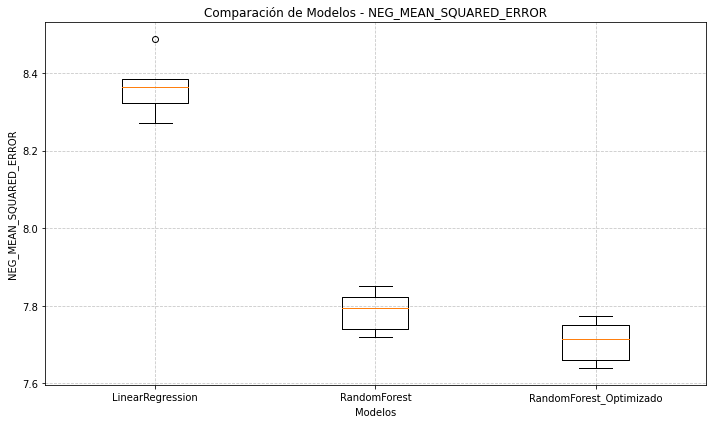

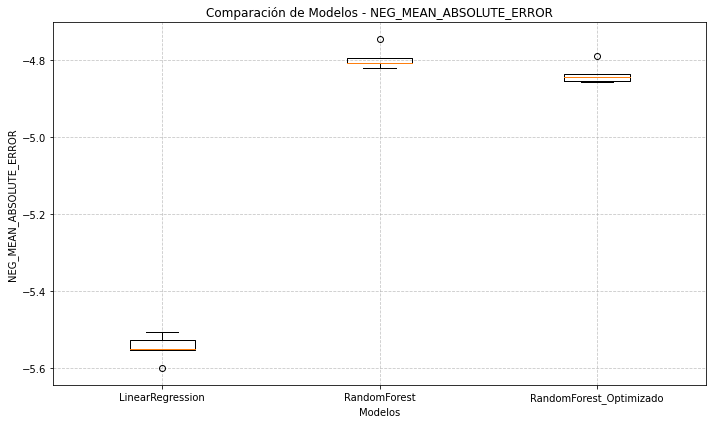

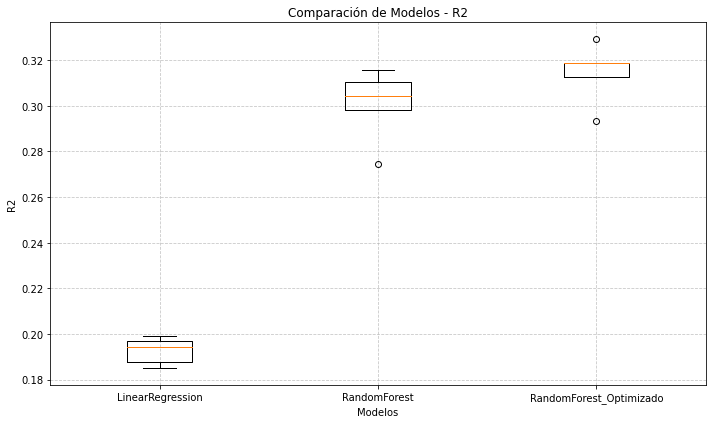

In [30]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

def evaluar_modelo(modelo, X, y, cv, scorers, model_name=None, n_jobs=-1):
    model_name = model_name or modelo.__class__.__name__
    resultados = {}

    for nombre, scorer in scorers.items():
        inicio = time()
        try:
            puntajes = cross_val_score(modelo, X, y, cv=cv, scoring=scorer, n_jobs=n_jobs)

            if isinstance(scorer, str) and scorer.startswith("neg_"):
                puntajes = np.abs(puntajes)
                if "squared" in scorer:
                    puntajes = np.sqrt(puntajes)

            resultados[nombre] = {
                'scores': puntajes,
                'mean': puntajes.mean(),
                'std': puntajes.std()
            }

            print(f"{model_name} - {nombre.upper()}: {puntajes.mean():.2f} ± {puntajes.std():.2f}")
        except Exception as e:
            print(f"[ERROR] {model_name} con métrica '{nombre}': {e}")
        finally:
            print(f"Tiempo ({nombre}): {time() - inicio:.2f}s\n")

    return resultados


def plot_model_comparison(results_dict, metric='neg_mean_squared_error'):
    plt.figure(figsize=(10, 6))
    scores = [res[metric]['scores'] for res in results_dict.values()]
    etiquetas = list(results_dict.keys())

    plt.boxplot(scores, labels=etiquetas)
    plt.title(f'Comparación de Modelos - {metric.upper()}')
    plt.ylabel(metric.upper())
    plt.xlabel('Modelos')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Definir métricas
scorers = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': 'r2'
}

# Validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Modelos base
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
}

# Búsqueda de hiperparámetros para RandomForest
rf_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
print("Optimizando hiperparámetros para RandomForest...")
inicio_opt = time()
rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=5,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
rf_search.fit(X_scaled, y)
print(f"Mejores parámetros RF: {rf_search.best_params_}")
print(f"Tiempo de optimización RF: {time() - inicio_opt:.2f} segundos")

models['RandomForest_Optimizado'] = rf_search.best_estimator_

# Evaluar todos los modelos
results_dict = {
    name: evaluar_modelo(model, X_scaled, y, kf, scorers, model_name=name)
    for name, model in models.items()
}

# Visualización
for metrica in scorers.keys():
    plot_model_comparison(results_dict, metric=metrica)


Implementación de redes neuronales

Dataset final: 105528 filas, 8 columnas
MLP_Base - RMSE: 8.13 ± 0.07
Tiempo (rmse): 17.91s

MLP_Base - MAE: -5.29 ± 0.04
Tiempo (mae): 17.24s

MLP_Base - R2: 0.24 ± 0.01
Tiempo (r2): 17.23s


Optimizando hiperparámetros para MLP...
Mejores parámetros MLP: {'max_iter': 500, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 64, 32), 'alpha': 0.01}
Tiempo de optimización MLP: 255.62 segundos
MLP_Optimizado - RMSE: 8.09 ± 0.07
Tiempo (rmse): 37.69s

MLP_Optimizado - MAE: -5.21 ± 0.03
Tiempo (mae): 37.87s

MLP_Optimizado - R2: 0.25 ± 0.01
Tiempo (r2): 37.87s



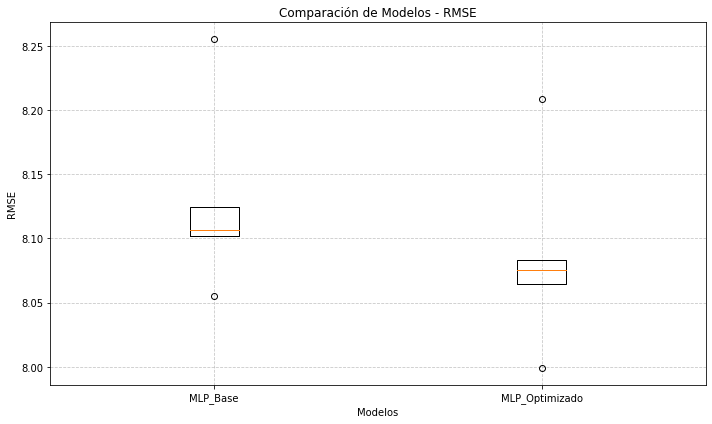

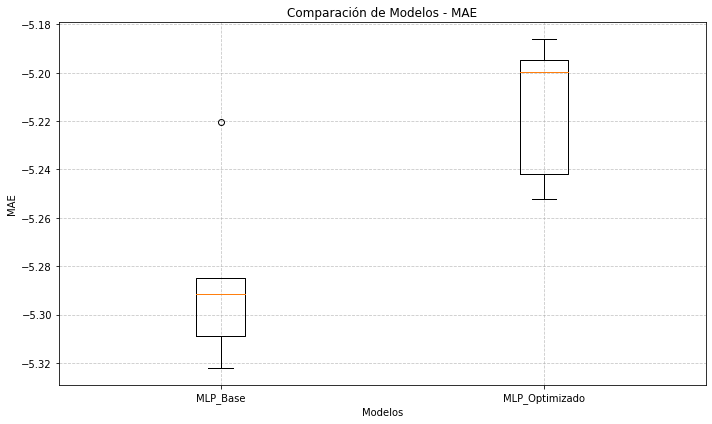

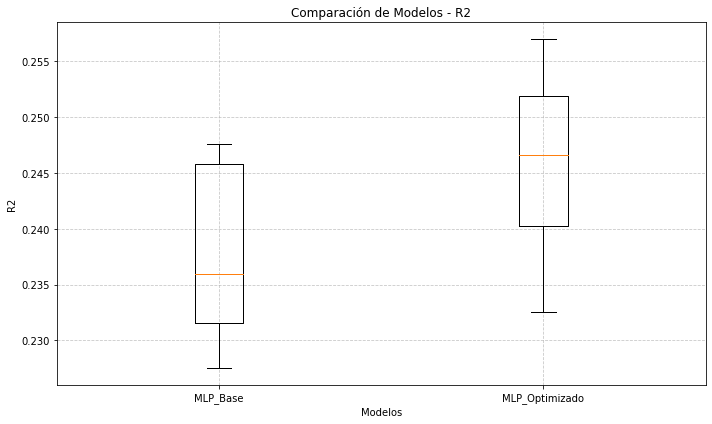

In [31]:

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

def evaluar_modelo(model, X, y, cv, scorers, model_name=None, n_jobs=-1):
    model_name = model_name or model.__class__.__name__
    results = {}

    for name, scorer in scorers.items():
        inicio = time()
        try:
            scores = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=n_jobs)

            # Procesamiento de métricas negativas
            if isinstance(scorer, str) and scorer.startswith("neg_"):
                scores = np.abs(scores)
                if "squared" in scorer:
                    scores = np.sqrt(scores)

            results[name] = {
                'scores': scores,
                'mean': scores.mean(),
                'std': scores.std()
            }

            print(f"{model_name} - {name.upper()}: {scores.mean():.2f} ± {scores.std():.2f}")
        except Exception as e:
            print(f"[ERROR] {model_name} con métrica '{name}': {e}")
        finally:
            print(f"Tiempo ({name}): {time() - inicio:.2f}s\n")

    return results



def graficar_modelo_comparacion(results_dict, metric='rmse'):
    plt.figure(figsize=(10, 6))
    scores = [results[metric]['scores'] for results in results_dict.values()]
    labels = list(results_dict.keys())
    plt.boxplot(scores, labels=labels)
    plt.title(f'Comparación de Modelos - {metric.upper()}')
    plt.ylabel(metric.upper())
    plt.xlabel('Modelos')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def carga_preprocesamiento_data(file_path, target, features, scaler_type='standard', impute_strategy='mean', outlier_threshold=3):
    df = pd.read_csv(file_path)
    
    if df.empty or not all(col in df.columns for col in features + [target]):
        raise ValueError("Archivo vacío o columnas faltantes")

    X = df[features].copy()
    y = df[target].copy()

    mask = X.notna().all(axis=1) & y.notna()
    X = X.loc[mask].reset_index(drop=True)
    y = y.loc[mask].reset_index(drop=True)

    X = pd.DataFrame(SimpleImputer(strategy=impute_strategy).fit_transform(X), columns=X.columns)

    skewed = ['price', 'freight_value', 'product_weight_g', 'product_length_cm',
              'product_height_cm', 'product_width_cm']
    for col in skewed:
        if col in X.columns and abs(X[col].skew()) > 1:
            X[col] = np.log1p(X[col])

    outlier_mask = (np.abs(zscore(X[skewed])) < outlier_threshold).all(axis=1)
    X = X[outlier_mask].reset_index(drop=True)
    y = y[outlier_mask].reset_index(drop=True)

    scaler = StandardScaler() if scaler_type == 'standard' else MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"Dataset final: {X_scaled.shape[0]} filas, {X_scaled.shape[1]} columnas")
    return X_scaled, y, scaler


# Configuración inicial
file_path = 'olist_dataset_modelado.csv'
target = 'delivery_time'
features = [
    'price', 'freight_value', 'review_score', 'product_weight_g',
    'product_length_cm', 'product_height_cm', 'product_width_cm',
    'product_category_encoded'
]

# Cargar y preprocesar datos
X_scaled, y, scaler = carga_preprocesamiento_data(
    file_path=file_path,
    target=target,
    features=features,
    scaler_type='standard',  #
    impute_strategy='mean',
    outlier_threshold=3
)

# Definir métricas
scorers = {
    'rmse': 'neg_mean_squared_error',
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': 'r2'
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Modelo MLP base
mlp_base = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,  
    early_stopping=True,  
    validation_fraction=0.1,
    alpha=0.01,  
    random_state=42
)

# Búsqueda de hiperparámetros para MLP
mlp_param_dist = {
    'hidden_layer_sizes': [(64, 32), (100, 50), (128, 64, 32), (100,)],
    'alpha': [0.0001, 0.01, 0.1],  
    'learning_rate_init': [0.001, 0.01],  
    'max_iter': [500, 1000]
}
mlp_search = RandomizedSearchCV(
    MLPRegressor(
        activation='relu',
        solver='adam',
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    ),
    param_distributions=mlp_param_dist,
    n_iter=8,  
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  
    random_state=42
)

# Evaluar modelos
results_dict = {}

# MLP base
results_dict['MLP_Base'] = evaluar_modelo(mlp_base, X_scaled, y, kf, scorers, model_name='MLP_Base')

# Optimizar hiperparámetros para MLP
print("\nOptimizando hiperparámetros para MLP...")
start_time = time()
mlp_search.fit(X_scaled, y)
print(f"Mejores parámetros MLP: {mlp_search.best_params_}")
print(f"Tiempo de optimización MLP: {time() - start_time:.2f} segundos")
results_dict['MLP_Optimizado'] = evaluar_modelo(
    mlp_search.best_estimator_, X_scaled, y, kf, scorers, model_name='MLP_Optimizado'
)

# Visualizar resultados
graficar_modelo_comparacion(results_dict, metric='rmse')
graficar_modelo_comparacion(results_dict, metric='mae')
graficar_modelo_comparacion(results_dict, metric='r2')